In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
dataOS = pd.read_excel("Ostatki3period.xlsx") #Теоретически сюда можно добавить другие БД
dataZA = pd.read_excel("Zakaz3period.xlsx")

dataZA = dataZA.T
dataZA.columns = dataZA.iloc[0]
dataZA.drop(["График по дням"], axis=0, inplace=True)
dataZA.drop(["Итого"], axis=0, inplace=True)
dataZA = dataZA.iloc[::-1]
dataZA.drop(["Показатели"], axis=0, inplace=True)

dataOS = dataOS.T
dataOS.columns = dataOS.iloc[0]
dataOS.drop(["График по дням"], axis=0, inplace=True)
dataOS.drop(["Итого"], axis=0, inplace=True)
dataOS = dataOS.iloc[::-1]
dataOS.drop(["Кластеры складов"], axis=0, inplace=True)


In [ ]:
#  СЮДА МОЖНО ДОБАВИТЬ ПРИЗНАКИ ДЛЯ ОТОБРАЖЕНИЯ ЛИНИЯМИ
# Настраиваем список переменных и их параметры отрисовки:

plot_config = [
        {
        'name': 'Показы', # Название на графике
        'label_in_file': 'Показы всего, шт.',# СЮДА пишем название колонки которую хотим отобразить!!!
        'normalization_type': 'normalized',  # normalized - значит будет нормализован   /   reference - верхняя планка для нормализации
        'color': 'red',
        'source': 'dataZA', # ЗДЕСЬ НАША БАЗА ДАННЫХ!!
        'type': 'single_column', # ТИП ОБАРБОТКИ sum_columns\single_column
        'linestyle': '-',
        'marker': 'o',
        'annotate': True, 
        'annotation_color': 'red',
        'annotation_fontsize': 8,
        'annotation_va': 'bottom'
    },
        {
        'name': 'Кластеры', # Название на графике
        'column_category': 'рфц',# СЮДА пишем название колонки которую хотим отобразить!!!
        'normalization_type': 'reference', # значит будет взят как эталон верхней планке(может быть не один - тогда будет взят наибольший)
        'color': 'purple', #цвет линии
        'source': 'dataOS', # ЗДЕСЬ НАША БАЗА ДАННЫХ!!
        'type': 'sum_columns', # ТИП ОБАРБОТКИ sum_columns= Считает, в скольких столбцах значение > 0 (по строкам)      single_column=просто отображает признак
        'linestyle': '-', # тип линии
        'marker': 'o', # тип точки
        'annotate': True, # отображение цифр на графике
        'annotation_color': 'purple', # цвет цифр точек
        'annotation_fontsize': 8, # размер точек
        'annotation_va': 'bottom' # -сверху\снизу цифра от точки 
        },
        {
        'name': 'Остатки (сумма по дням)',
        'column_category': 'остатки',
        'normalization_type': 'reference',
        'color': 'green',
        'source': 'dataOS',
        'type': 'sum_columns',
        'linestyle': '-',
        'marker': 'o',
        'annotate': True,
        'annotation_color': 'green',
        'annotation_fontsize': 8,
        'annotation_va': 'bottom'
        },
    #     {
    #     'name': 'Показы (views)',
    #     'label_in_file': 'Заказано товаров, шт.',
    #     'normalization_type': 'normalized',  
    #     'color': 'blue',
    #     'source': 'dataZA',
    #     'type': 'single_column',
    #     'linestyle': '-',
    #     'marker': 'o',
    #     'annotate': True,
    #     'annotation_color': 'red',
    #     'annotation_fontsize': 8,
    #     'annotation_va': 'bottom'
    # },
    #     {
    #     'name': 'Себестоимость выкупленных товаров, руб.',
    #     'label_in_file': 'Себестоимость выкупленных товаров, руб.',
    #     'normalization_type': 'normalized', 
    #     'color': 'orange',
    #     'source': 'dataZA',
    #     'type': 'single_column',
    #     'linestyle': '-',
    #     'marker': 'o',
    #     'annotate': True,
    #     'annotation_color': 'orange',
    #     'annotation_fontsize': 8,
    #     'annotation_va': 'bottom'
    # },
]



In [ ]:

def clean_columns(df, column_indices):
    cleaned_df = pd.DataFrame()
    for col in column_indices:
        col_data = df.iloc[:, col]  # всегда по индексу!
        clean_col = (
            col_data.astype(str)
            .str.replace("—", "0")
            .str.replace(r"[^\d.-]", "", regex=True)
            .replace("", "0")
            .apply(pd.to_numeric, errors='coerce')
            .fillna(0)
        )
        cleaned_df[col] = clean_col
    return (pd.DataFrame(cleaned_df).T > 0).sum(axis=0)

def clean_single_column(df, index):
    col_data = df.iloc[:, index]
    clean_col = (
        col_data.astype(str)
        .str.replace("—", "0")
        .str.replace(r"[^\d.-]", "", regex=True)
        .replace("", "0")
        .apply(pd.to_numeric, errors='coerce')
        .fillna(0)
    )
    return clean_col

def classify_dataOS_columns(df):
    categories = {
        'остатки': [],
        'рфц': [],
        'заказы': [],
        'регионы': []
    }

    for i, col in enumerate(df.columns):
        col_lower = str(col).strip().lower()

        if 'остат' in col_lower or 'stock' in col_lower:
            categories['остатки'].append(i)
        elif 'рфц' in col_lower or 'rfc' in col_lower:
            categories['рфц'].append(i)
        elif 'заказ' in col_lower or 'order' in col_lower:
            categories['заказы'].append(i)
        else:
            categories['регионы'].append(i)

    return categories

In [ ]:
def extract_series(config, dataZA, dataOS, column_map=None):
    source = config['source']
    data = dataZA if source == 'dataZA' else dataOS
    type_ = config['type']

    if type_ == 'single_column':
        col_name = config['label_in_file'].strip().lower()
        index = next((i for i, c in enumerate(data.columns) if str(c).strip().lower() == col_name), None)
        if index is not None:
            return clean_single_column(data, index)
        else:
            print(f"❌ Не найдена колонка: {col_name}")
            return None

    elif type_ == 'sum_columns':
        category = config['column_category'].strip().lower()
        if column_map and category in column_map:
            indices = column_map[category]
            return clean_columns(data, indices)
        else:
            print(f"❌ Не найдена категория: {category}")
            return None

    else:
        print(f"❌ Неизвестный тип: {type_}")
        return None


columns_by_category = classify_dataOS_columns(dataOS)

for config in plot_config:
    series = extract_series(config, dataZA, dataOS, column_map=columns_by_category)
    if series is not None:
        config['series'] = series#.fillna(0)


reference_series = [
    conf['series'] for conf in plot_config
    if conf.get('normalization_type') == 'reference'
]

normalized_configs = [
    conf for conf in plot_config
    if conf.get('normalization_type') == 'normalized'
]

max_reference_value = max(
    (s.max() for s in reference_series if s is not None and s.max() != 0),
    default=1  # чтобы не было деления на 0
)

for conf in normalized_configs:
    s = conf.get('series')
    if s is not None and s.max() != 0:
        conf['series'] = s / s.max() * max_reference_value


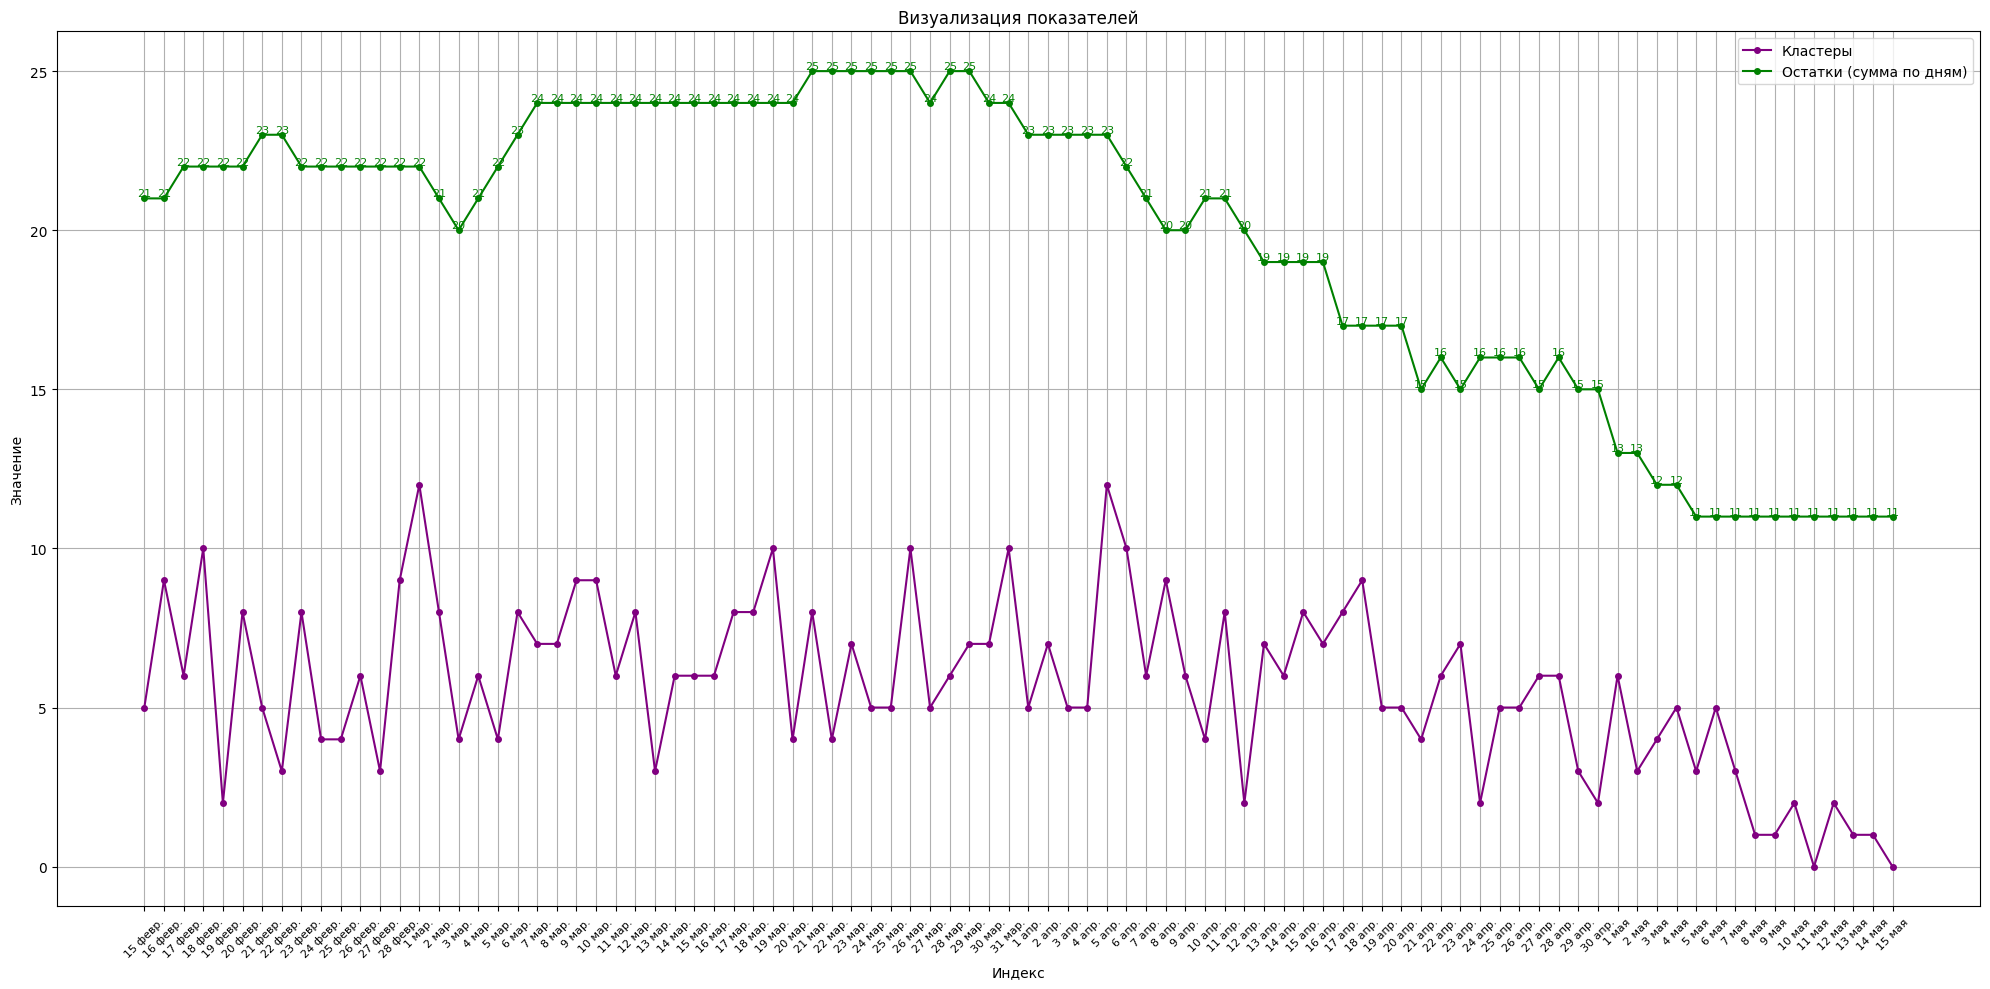

In [133]:
plt.figure(figsize=(20, 10))
for config in plot_config:
    if 'series' not in config:
        continue
    series = config['series']
    plt.plot(
        series.index,
        series.values,
        label=config['name'],
        color=config['color'],
        linestyle=config['linestyle'],
        marker=config['marker'],
        linewidth=1.5,
        markersize=4
    )
    if config.get('annotate', False):
        for x, y in zip(series.index, series.values):
            if pd.notna(y):
                plt.text(
                    x, y, f'{int(y)}',
                    ha='center',
                    va=config.get('annotation_va', 'bottom'),
                    color=config.get('annotation_color', config['color']),
                    fontsize=config.get('annotation_fontsize', 8)
                )

plt.title('Визуализация показателей')
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()